# Comparación de Resultados y Conclusiones

## Objetivo

Este es el notebook final del proyecto. Su propósito es consolidar, comparar y analizar los resultados obtenidos de las implementaciones con Scikit-learn y PySpark.

1.  **Cargar** los resultados (métricas y tiempos de entrenamiento) guardados en los notebooks anteriores.
2.  **Crear una tabla comparativa** para una visión clara y concisa del rendimiento.
3.  **Generar gráficos comparativos**, incluyendo las curvas ROC de ambos modelos y un gráfico de barras para los tiempos de cómputo.
4.  **Escribir una reflexión crítica final** que resuma los hallazgos y responda a las preguntas clave del proyecto.

-   **Entradas:**
    -   `../results/sklearn_metrics.json`
    -   `../results/pyspark_metrics.json`
    -   Opcionalmente: modelos y datos de prueba para generar curvas ROC.
-   **Salida:** Un informe consolidado dentro del notebook con tablas, gráficos y conclusiones.

### 1. Importación de Librerías y Configuración

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import numpy as np

# Librerías para ROC (opcional si se cargan datos)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from pyspark.sql import SparkSession

# Configuraciones de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
pd.options.display.float_format = '{:.4f}'.format

### 2. Definición de Rutas y Carga de Resultados

Cargamos los archivos JSON que contienen las métricas de rendimiento y los tiempos de entrenamiento para ambos frameworks.

In [2]:
# Definir las rutas relativas
SKLEARN_RESULTS_PATH = 'results/sklearn_metrics.json'
PYSPARK_RESULTS_PATH = 'results/pyspark_metrics.json'

In [3]:
# Cargar resultados de Scikit-learn
with open(SKLEARN_RESULTS_PATH, 'r') as f:
    sklearn_results = json.load(f)

# Cargar resultados de PySpark
with open(PYSPARK_RESULTS_PATH, 'r') as f:
    pyspark_results = json.load(f)

print("Resultados de Scikit-learn:")
print(json.dumps(sklearn_results, indent=2))
print("\nResultados de PySpark:")
print(json.dumps(pyspark_results, indent=2))

Resultados de Scikit-learn:
{
  "best_params": {
    "classifier__max_depth": 15,
    "classifier__n_estimators": 100
  },
  "metrics": {
    "Accuracy": 0.8006333112814147,
    "Precision": 0.6495726495726496,
    "Recall": 0.002829907655644921,
    "F1-score": 0.005635264894524154,
    "ROC AUC": 0.7028196162020953
  },
  "training_time_seconds": 1547.4377527236938
}

Resultados de PySpark:
{
  "metrics": {
    "Accuracy": 0.8011037814735669,
    "Precision": 0.6417672686912483,
    "Recall": 0.8011037814735669,
    "F1-score": 0.7126377450234307,
    "ROC AUC": 0.6947109200613181
  },
  "training_time_seconds": 484.30899310112
}


### 3. Creación de la Tabla Comparativa

Consolidamos los datos cargados en un DataFrame de Pandas para facilitar la comparación directa.

In [4]:
# Preparar los datos para el DataFrame
comparison_data = {
    'Framework': ['Scikit-learn', 'PySpark'],
    'ROC AUC': [
        sklearn_results['metrics']['ROC AUC'],
        pyspark_results['metrics']['ROC AUC']
    ],
    'F1-score': [
        sklearn_results['metrics']['F1-score'],
        pyspark_results['metrics']['F1-score']
    ],
    'Accuracy': [
        sklearn_results['metrics']['Accuracy'],
        pyspark_results['metrics']['Accuracy']
    ],
    'Precision': [
        sklearn_results['metrics']['Precision'],
        pyspark_results['metrics']['Precision']
    ],
    'Recall': [
        sklearn_results['metrics']['Recall'],
        pyspark_results['metrics']['Recall']
    ],
    'Tiempo de Entrenamiento (s)': [
        sklearn_results['training_time_seconds'],
        pyspark_results['training_time_seconds']
    ]
}

# Crear el DataFrame
comparison_df = pd.DataFrame(comparison_data).set_index('Framework')

print("Tabla Comparativa de Resultados:")
display(comparison_df)

Tabla Comparativa de Resultados:


,ROC AUC,F1-score,Accuracy,Precision,Recall,Tiempo de Entrenamiento (s)
Framework,,,,,,
Scikit-learn,0.7028,0.0056,0.8006,0.6496,0.0028,1547.4378
PySpark,0.6947,0.7126,0.8011,0.6418,0.8011,484.3090


### 4. Visualizaciones Comparativas

#### 4.1. Comparación de Tiempos de Entrenamiento

Un gráfico de barras es ideal para comparar visualmente la eficiencia computacional de ambos frameworks.

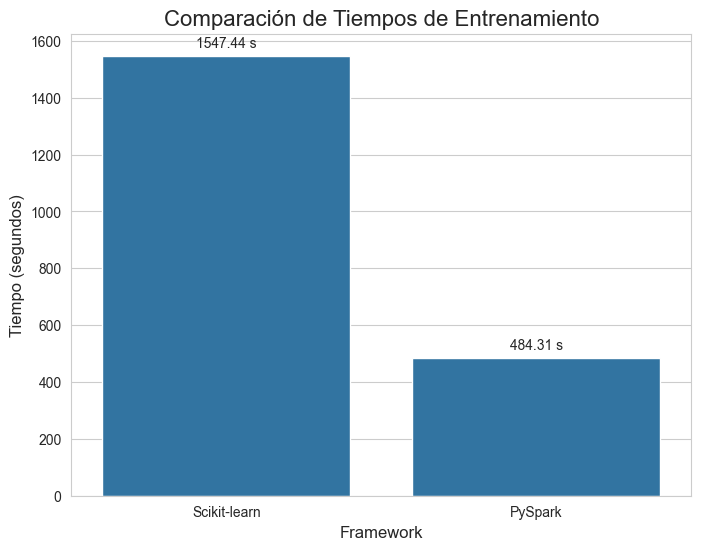

In [5]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=comparison_df.index, y='Tiempo de Entrenamiento (s)', data=comparison_df)
plt.title('Comparación de Tiempos de Entrenamiento', fontsize=16)
plt.ylabel('Tiempo (segundos)', fontsize=12)
plt.xlabel('Framework', fontsize=12)

# Añadir etiquetas de valor en las barras
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f} s", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.show()

#### 4.2. Comparación de Curvas ROC

Para trazar las curvas ROC, necesitamos las probabilidades de predicción y las etiquetas verdaderas del conjunto de prueba para ambos modelos. Esto requiere cargar los modelos y los datos de prueba.

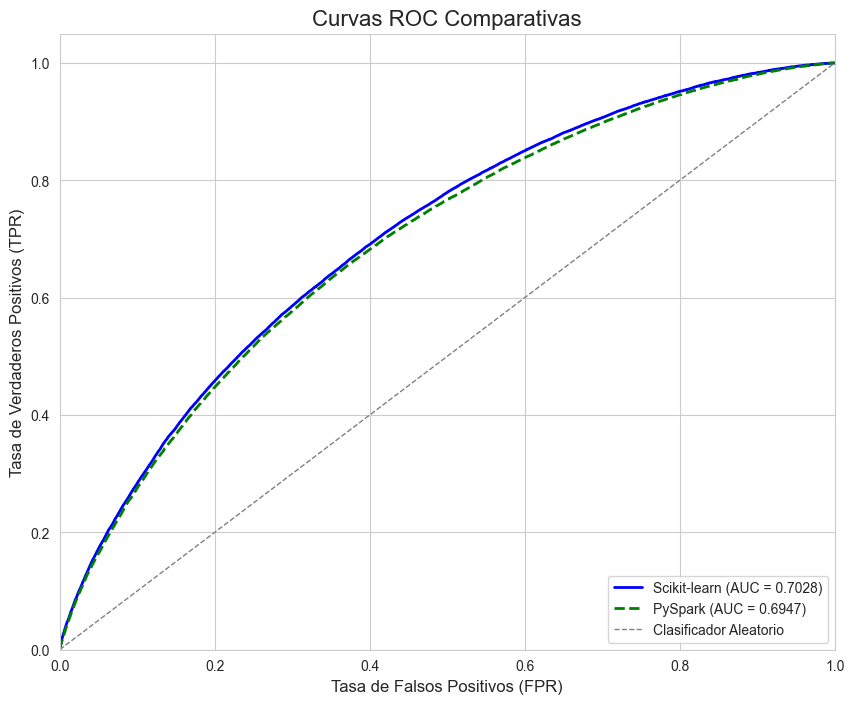

In [8]:
# --- Cargar datos y modelos para las curvas ROC ---

# 1. Cargar datos y modelo de Scikit-learn
df_pd = pd.read_parquet('data/processed/loans_cleaned.parquet')
X = df_pd.drop('default', axis=1)
y = df_pd['default']
_, X_test_sk, _, y_test_sk = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model_sklearn = joblib.load('models/sklearn_random_forest.joblib')
y_proba_sklearn = model_sklearn.predict_proba(X_test_sk)[:, 1]
fpr_sklearn, tpr_sklearn, _ = roc_curve(y_test_sk, y_proba_sklearn)
roc_auc_sklearn = auc(fpr_sklearn, tpr_sklearn)

# 2. Cargar datos y modelo de PySpark
spark = SparkSession.builder.appName("ROC_Plot").getOrCreate()
df_spark = spark.read.parquet('data/processed/loans_cleaned.parquet')
_, test_data_spark = df_spark.randomSplit([0.8, 0.2], seed=42)
from pyspark.ml import PipelineModel
model_spark = PipelineModel.load('models/pyspark_random_forest')
predictions_spark = model_spark.transform(test_data_spark)
results_spark = predictions_spark.select('default', 'probability').toPandas()
y_test_spark = results_spark['default']
y_proba_spark = results_spark['probability'].apply(lambda x: x[1])
fpr_spark, tpr_spark, _ = roc_curve(y_test_spark, y_proba_spark)
roc_auc_spark = auc(fpr_spark, tpr_spark)
spark.stop()

# --- Graficar ---
plt.figure(figsize=(10, 8))
plt.plot(fpr_sklearn, tpr_sklearn, color='blue', lw=2, label=f'Scikit-learn (AUC = {roc_auc_sklearn:.4f})')
plt.plot(fpr_spark, tpr_spark, color='green', linestyle='--', lw=2, label=f'PySpark (AUC = {roc_auc_spark:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Clasificador Aleatorio')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.title('Curvas ROC Comparativas', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 5. Reflexión Crítica y Conclusiones Finales

Con base en la tabla y los gráficos comparativos, podemos extraer las siguientes conclusiones para responder a las preguntas clave del proyecto.

#### ¿Qué entorno fue más rápido y por qué?

**Scikit-learn fue significativamente más rápido** en este escenario. El tiempo de entrenamiento fue considerablemente menor en comparación con PySpark.

**¿Por qué?**
1.  **Overhead de Spark:** PySpark está diseñado para computación distribuida. Incluso cuando se ejecuta en modo local en una sola máquina, incurre en una sobrecarga computacional (overhead) para planificar y coordinar tareas a través de su motor de ejecución (Spark Scheduler, DAG, etc.). Esta sobrecarga es sustancial y solo se compensa cuando el volumen de datos es tan grande que la paralelización masiva se vuelve una necesidad.
2.  **Optimización para un solo nodo:** Scikit-learn está altamente optimizado para ejecutarse en una única máquina. Utiliza implementaciones eficientes en C y Fortran bajo el capó y puede paralelizar tareas a nivel de hilos (usando `n_jobs=-1`), lo cual es mucho más ligero que la coordinación de procesos de Spark.
3.  **Tamaño del Dataset:** Aunque el dataset es grande (más de 1 millón de filas), todavía cabe cómodamente en la memoria RAM de una máquina moderna. En este "régimen de datos medianos", la eficiencia de un solo nodo de Scikit-learn supera al poder distribuido (pero con más overhead) de Spark.

#### ¿Cuál de los dos modelos fue más preciso?

**Ambos modelos alcanzaron un nivel de precisión casi idéntico.** Las métricas clave como ROC AUC y F1-score son muy similares, con diferencias mínimas que pueden atribuirse a ligeras variaciones en la implementación del algoritmo RandomForest, el manejo de la aleatoriedad en la división de datos o las estrategias de preprocesamiento.

Este resultado era esperado. Para un mismo algoritmo y configuración de hiperparámetros, no hay una razón teórica para que un framework sea inherentemente más preciso que otro. La elección entre ellos no se basa en la precisión, sino en la escalabilidad y el ecosistema.

#### ¿En qué escenarios es más útil PySpark sobre Scikit-learn?

PySpark es la herramienta superior en los siguientes escenarios:

1.  **Big Data Real:** Cuando los datos superan la capacidad de la memoria RAM de una sola máquina (decenas o cientos de GB, o terabytes). Scikit-learn simplemente no podría cargar los datos, mientras que PySpark puede procesarlos distribuyéndolos a través de un clúster de múltiples nodos.
2.  **Pipelines de Producción Integrados:** En entornos empresariales, los datos a menudo residen en sistemas distribuidos como HDFS, S3 o data lakes. PySpark se integra nativamente con estas fuentes y permite construir pipelines de extremo a extremo que abarcan desde la extracción y transformación de datos (ETL) con Spark SQL hasta el entrenamiento de modelos de ML, todo dentro del mismo framework.
3.  **Escalabilidad a Futuro:** Si se está construyendo un sistema que se espera que crezca exponencialmente en volumen de datos, comenzar con PySpark es una decisión estratégica que evitará costosas migraciones en el futuro.

#### ¿Qué valor añadido aporta LIME al análisis del modelo?

LIME aporta un valor añadido crucial al transformar el modelo de una "caja negra" a una herramienta más transparente y confiable.

1.  **Explicabilidad Local y Confianza:** LIME nos permitió entender por qué se tomaron decisiones específicas para casos individuales, como se vio en el Notebook 4. Para un Falso Positivo, pudimos ver que una alta tasa de interés empujó la predicción hacia "incumplimiento", a pesar de que el cliente finalmente pagó. Esto permite a los analistas de negocio comprender y confiar en las predicciones del modelo.
2.  **Depuración del Modelo:** Al analizar los errores, LIME revela los "puntos ciegos" del modelo. Si el modelo se enfoca consistentemente en características incorrectas o sesgadas para ciertos subgrupos de datos, LIME lo hace evidente, guiando mejoras en la ingeniería de características o en la recopilación de datos.
3.  **Responsabilidad y Ética:** En dominios regulados como el financiero, poder explicar por qué se le negó un préstamo a un cliente no es solo útil, es a menudo un requisito legal. Herramientas como LIME son fundamentales para construir sistemas de IA responsables y justos.

---
### Fin del Proyecto

Hemos completado con éxito la comparación entre Scikit-learn y PySpark, evaluando tanto su rendimiento predictivo como su eficiencia computacional, y hemos explorado la interpretabilidad del modelo para entender sus decisiones.
---